## Import TensorFlow and other libraries

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

## Load the dataset
To start, you will train the basic autoencoder using the Fashion MNIST dataset. Each image in this dataset is 28x28 pixels.

In [96]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


## First example: Basic autoencoder
![Basic autoencoder results](images/intro_autoencoder_result.png)

Define an autoencoder with two Dense layers: an `encoder`, which compresses the images into a 64 dimensional latent vector, and a `decoder`, that reconstructs the original image from the latent space.

To define your model, use the [Keras Model Subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models).


In [97]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


shape = x_test.shape[1:]
latent_dim = 64
autoencoder = Autoencoder(latent_dim, shape)


In [98]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

Train the model using `x_train` as both the input and the target. The `encoder` will learn to compress the dataset from 784 dimensions to the latent space, and the `decoder` will learn to reconstruct the original images.
.

In [99]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [100]:
%%time

with tf.device('/device:GPU:0'):
    history1 = autoencoder.fit(x_train, x_train,
                epochs=50,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0239 - val_loss: 0.0133
Epoch 2/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0117 - val_loss: 0.0106
Epoch 3/50
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0101 - val_loss: 0.0098
Epoch 4/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0095 - val_loss: 0.0093
Epoch 5/50
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 6/50
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 7/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0089 - val_loss: 0.0090
Epoch 8/50
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 9/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 10/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.008

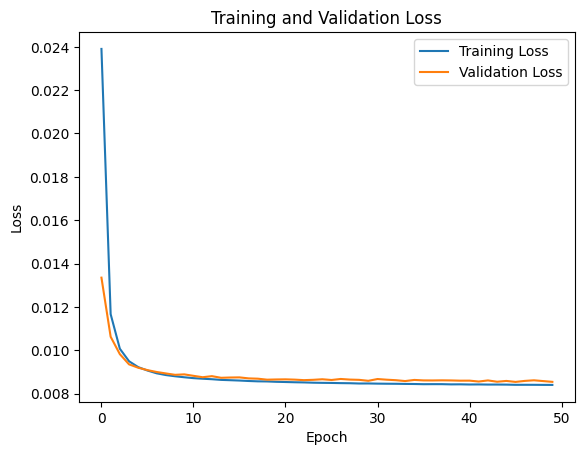

In [101]:
# Extract loss values from history
train_loss = history1.history['loss']
val_loss = history1.history['val_loss']

# Plot training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Now that the model is trained, let's test it by encoding and decoding images from the test set.

In [102]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

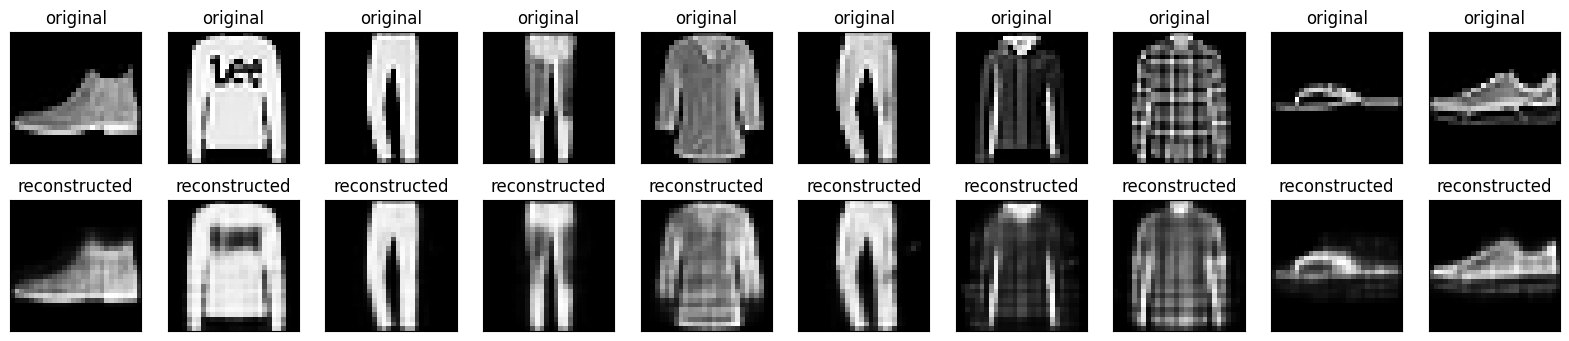

In [103]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Second example: Image denoising


![Image denoising results](images/image_denoise_fmnist_results.png)

An autoencoder can also be trained to remove noise from images. In the following section, you will create a noisy version of the Fashion MNIST dataset by applying random noise to each image. You will then train an autoencoder using the noisy image as input, and the original image as the target.

Let's reimport the dataset to omit the modifications made earlier.

In [5]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [6]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


Adding random noise to the images

In [7]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

In [40]:
import numpy as np

# Function to create random mask
def create_random_mask(image_shape, patch_size=(4, 4)):
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    num_patches = (image_shape[0] * image_shape[1]) // (patch_size[0] * patch_size[1])
    num_masked_patches = num_patches // 16 * 8  # Approximately 1/16th of the patches to be masked

    # Generate random positions for the masked patches
    masked_patch_indices = np.random.choice(num_patches, num_masked_patches, replace=False)

    # Convert indices to 2D coordinates
    patch_coords = np.unravel_index(masked_patch_indices, (image_shape[0] // patch_size[0], image_shape[1] // patch_size[1]))

    # Set corresponding regions to 1 in the mask
    for i, j in zip(*patch_coords):
        mask[i * patch_size[0]:(i + 1) * patch_size[0], j * patch_size[1]:(j + 1) * patch_size[1]] = 1

    return mask

In [41]:
x_train.shape

(60000, 28, 28, 1)

In [42]:
# Create random masks for x_train and x_test
x_train_masks = [create_random_mask(x_train.shape[1:3]) for _ in range(len(x_train))]
x_test_masks = [create_random_mask(x_test.shape[1:3]) for _ in range(len(x_test))]

In [43]:
x_train_masks = np.array(x_train_masks)
x_test_masks = np.array(x_test_masks)
x_train_masks.shape, x_test_masks.shape

((60000, 28, 28), (10000, 28, 28))

In [44]:
# Apply masks to x_train
x_train_masked = x_train * x_train_masks[..., np.newaxis]
x_test_masked = x_test * x_test_masks[..., np.newaxis]

# Verify the shape of x_train_masked
print("Shape of x_train_masked:", x_train_masked.shape)
print("Shape of x_test_masked:", x_test_masked.shape)

Shape of x_train_masked: (60000, 28, 28, 1)
Shape of x_test_masked: (10000, 28, 28, 1)


Plot the noisy images.


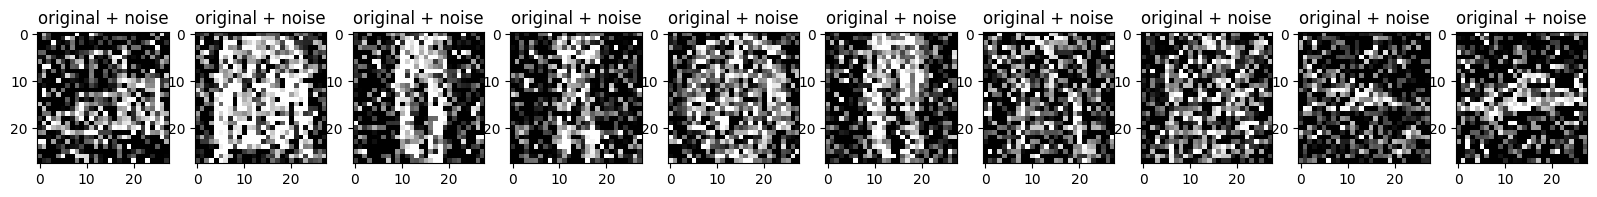

In [45]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

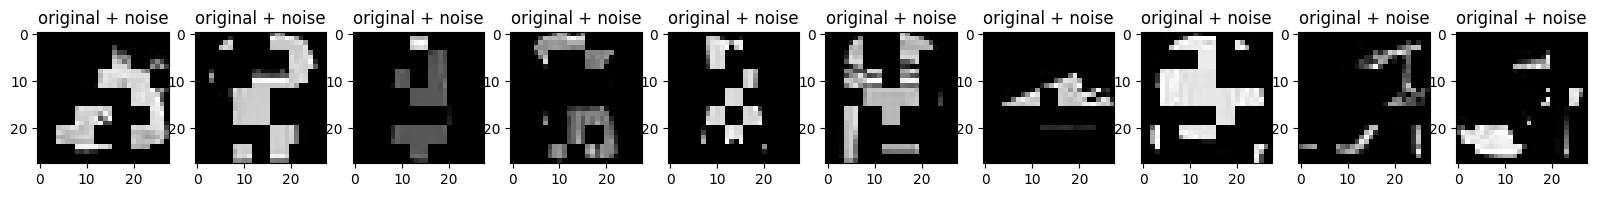

In [46]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_train_masked[i]))
    plt.gray()
plt.show()

### Define a convolutional autoencoder

In this example, you will train a convolutional autoencoder using  [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) layers in the `encoder`, and [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) layers in the `decoder`.

In [47]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [48]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
%%time

with tf.device('/device:GPU:0'):
    history2 = autoencoder.fit(x_train_noisy, x_train,
                epochs=50,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/50
1875/1875 [==============================] - 59s 30ms/step - loss: 0.0296 - val_loss: 0.0213
Epoch 2/50
1875/1875 [==============================] - 79s 42ms/step - loss: 0.0208 - val_loss: 0.0204
Epoch 3/50
1875/1875 [==============================] - 70s 38ms/step - loss: 0.0201 - val_loss: 0.0200
Epoch 4/50
1875/1875 [==============================] - 70s 38ms/step - loss: 0.0196 - val_loss: 0.0196
Epoch 5/50
1875/1875 [==============================] - 70s 37ms/step - loss: 0.0193 - val_loss: 0.0193
Epoch 6/50
1875/1875 [==============================] - 69s 37ms/step - loss: 0.0191 - val_loss: 0.0191
Epoch 7/50
1875/1875 [==============================] - 56s 30ms/step - loss: 0.0189 - val_loss: 0.0190
Epoch 8/50
1875/1875 [==============================] - 68s 36ms/step - loss: 0.0188 - val_loss: 0.0188
Epoch 9/50
1875/1875 [==============================] - 72s 38ms/step - loss: 0.0186 - val_loss: 0.0186
Epoch 10/50
1875/1875 [==============================] - 74s 39m

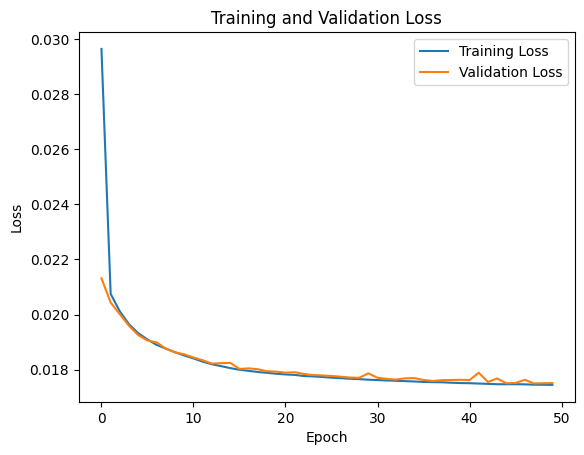

In [ ]:
# Extract loss values from history
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']

# Plot training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Let's take a look at a summary of the encoder. Notice how the images are downsampled from 28x28 to 7x7.

In [ ]:
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1320 (5.16 KB)
Trainable params: 1320 (5.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The decoder upsamples the images back from 7x7 to 28x28.

In [ ]:
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTr  (None, 14, 14, 8)         584       
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 16)        1168      
 Transpose)                                                      
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1897 (7.41 KB)
Trainable params: 1897 (7.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Plotting both the noisy images and the denoised images produced by the autoencoder.

In [ ]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

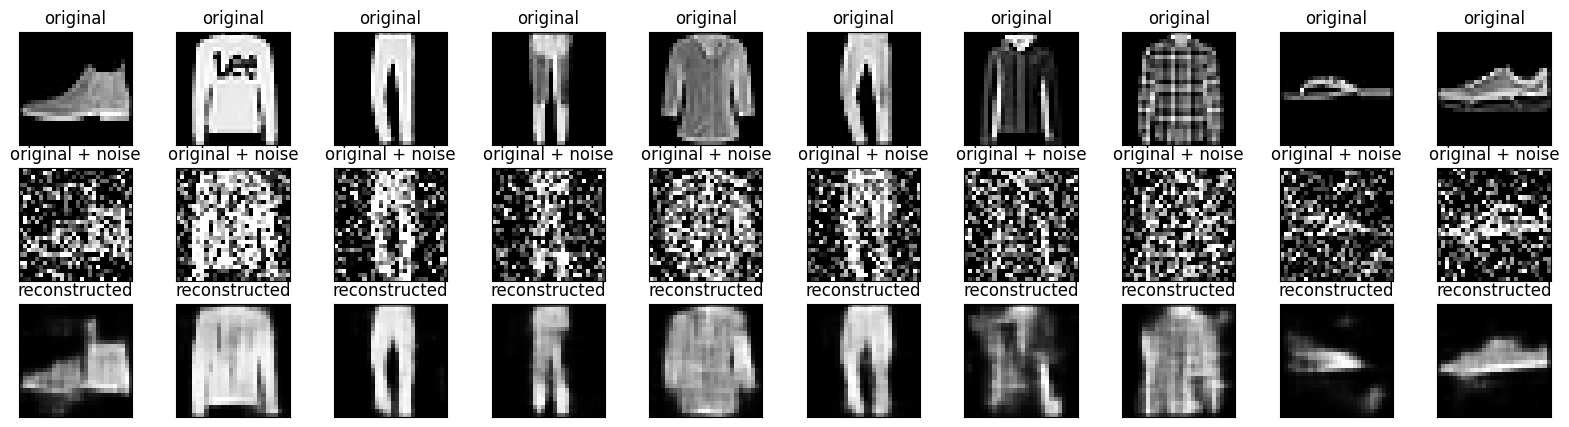

In [ ]:
n = 10
plt.figure(figsize=(20, 5))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display original + noise
    ax = plt.subplot(3, n, i + n + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(3, n, i + 2*n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

plt.show()

### Define a vapad model

In this example, you will train a convolutional autoencoder using  [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) layers in the `encoder`, and [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) layers in the `decoder`.

In [32]:
! pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.9 MB/s eta 0:00:00


In [33]:
from vapad import *

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [116]:
vapad = VapadModel(input_shape=(28, 28, 1))
autoencoder = vapad.build_vapad_model()

In [117]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [118]:
%%time

with tf.device('/device:GPU:0'):
    history3 = autoencoder.fit(x_train_noisy, x_train,
                epochs=50,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/50
1875/1875 [==============================] - 111s 44ms/step - loss: 0.0457 - val_loss: 0.0465
Epoch 2/50
1875/1875 [==============================] - 81s 43ms/step - loss: 0.0403 - val_loss: 0.0362
Epoch 3/50
1875/1875 [==============================] - 81s 43ms/step - loss: 0.0391 - val_loss: 0.0352
Epoch 4/50
1875/1875 [==============================] - 81s 43ms/step - loss: 0.0377 - val_loss: 0.0394
Epoch 5/50
1875/1875 [==============================] - 82s 43ms/step - loss: 0.0367 - val_loss: 0.0337
Epoch 6/50
1875/1875 [==============================] - 80s 43ms/step - loss: 0.0359 - val_loss: 0.0361
Epoch 7/50
1875/1875 [==============================] - 82s 44ms/step - loss: 0.0353 - val_loss: 0.0349
Epoch 8/50
1875/1875 [==============================] - 84s 45ms/step - loss: 0.0351 - val_loss: 0.0358
Epoch 9/50
1875/1875 [==============================] - 84s 45ms/step - loss: 0.0346 - val_loss: 0.0342
Epoch 10/50
1875/1875 [==============================] - 83s 44

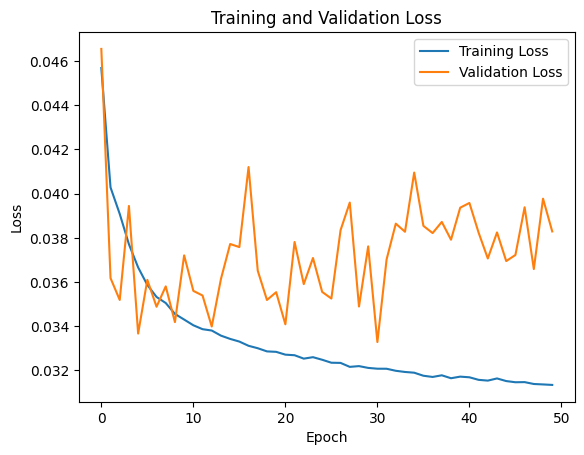

In [119]:
# Extract loss values from history
train_loss = history3.history['loss']
val_loss = history3.history['val_loss']

# Plot training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Plot the model.

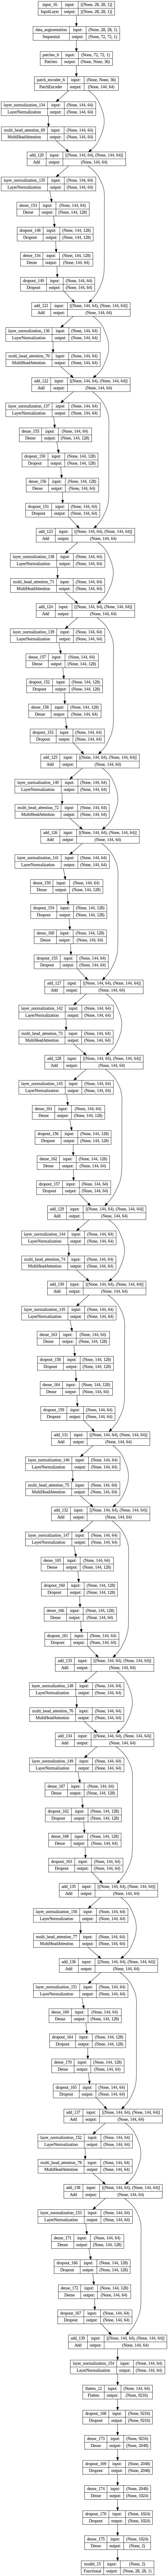

In [44]:
tf.keras.utils.plot_model(autoencoder, show_shapes=True)

Plotting both the noisy images and the denoised images produced by the autoencoder.

1/1 [==============================] - 0s 38ms/step


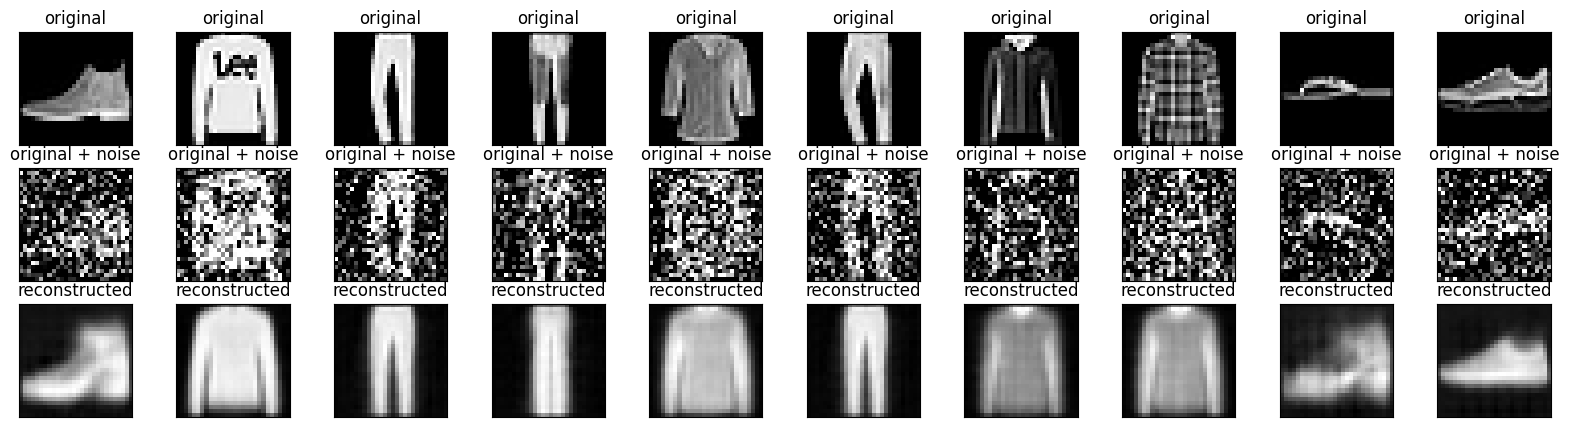

In [120]:
n = 10
plt.figure(figsize=(20, 5))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display original + noise
    ax = plt.subplot(3, n, i + n + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(3, n, i + 2*n + 1)
    plt.title("reconstructed")
    reconstructed_img = autoencoder.predict(tf.expand_dims(x_test_noisy[i], axis=0)).reshape(28, 28)
    plt.imshow(tf.squeeze(reconstructed_img))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

plt.show()

## Third example: Image recovering


![Image denoising results](images/image_denoise_fmnist_results.png)

An autoencoder can also be trained to remove noise from images. In the following section, you will create a noisy version of the Fashion MNIST dataset by applying random noise to each image. You will then train an autoencoder using the noisy image as input, and the original image as the target.

Let's reimport the dataset to omit the modifications made earlier.

In [121]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [122]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


Adding random masks to the images

In [123]:
import numpy as np

# Define function to create masks with random blank spots
def create_random_masks(images, mask_size=(8, 8)):
    masked_images = []
    for image in images:
        # Copy the original image
        masked_image = np.copy(image)
        # Generate random positions for the blank spot
        x_pos = np.random.randint(0, image.shape[0] - mask_size[0])
        y_pos = np.random.randint(0, image.shape[1] - mask_size[1])
        # Apply the blank spot to the image
        masked_image[x_pos:x_pos+mask_size[0], y_pos:y_pos+mask_size[1]] = 0
        masked_images.append(masked_image)
    return np.array(masked_images)

In [124]:
# Apply the function to both training and testing data
x_train_masked = create_random_masks(x_train)
x_test_masked = create_random_masks(x_test)

In [125]:
import numpy as np

# Define function to create masks with random blank spots
def create_random_masks(images, mask_size=(8, 8)):
    masked_images = []
    for image in images:
        # Copy the original image
        masked_image = np.copy(image)
        # Generate random positions for the blank spot
        x_pos = np.random.randint(0, image.shape[0] - mask_size[0])
        y_pos = np.random.randint(0, image.shape[1] - mask_size[1])
        # Apply the blank spot to the image
        masked_image[x_pos:x_pos+mask_size[0], y_pos:y_pos+mask_size[1]] = 0
        masked_images.append(masked_image)
    return np.array(masked_images)

In [126]:
# Apply the function to both training and testing data
x_train_masked = create_random_masks(x_train)
x_test_masked = create_random_masks(x_test)

Plot the noisy images.


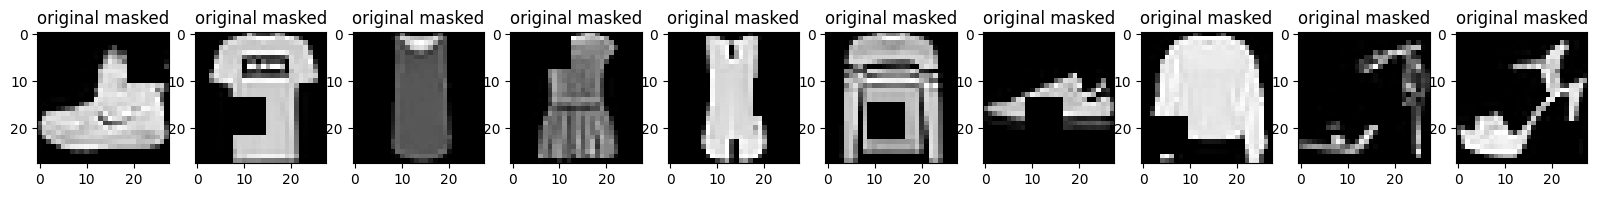

In [127]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original masked")
    plt.imshow(tf.squeeze(x_train_masked[i]))
    plt.gray()
plt.show()

In [128]:
vapad = VapadModel(input_shape=(28, 28, 1))
autoencoder = vapad.build_vapad_model()

In [129]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [130]:
%%time

with tf.device('/device:GPU:0'):
    history4 = autoencoder.fit(x_train_masked, x_train,
                epochs=50,
                shuffle=True,
                validation_data=(x_test_masked, x_test))

Epoch 1/50
1875/1875 [==============================] - 119s 47ms/step - loss: 0.0447 - val_loss: 0.0401
Epoch 2/50
1875/1875 [==============================] - 88s 47ms/step - loss: 0.0401 - val_loss: 0.0355
Epoch 3/50
1875/1875 [==============================] - 88s 47ms/step - loss: 0.0391 - val_loss: 0.0341
Epoch 4/50
1875/1875 [==============================] - 88s 47ms/step - loss: 0.0381 - val_loss: 0.0333
Epoch 5/50
1875/1875 [==============================] - 88s 47ms/step - loss: 0.0372 - val_loss: 0.0335
Epoch 6/50
1875/1875 [==============================] - 88s 47ms/step - loss: 0.0363 - val_loss: 0.0325
Epoch 7/50
1875/1875 [==============================] - 88s 47ms/step - loss: 0.0358 - val_loss: 0.0323
Epoch 8/50
1875/1875 [==============================] - 88s 47ms/step - loss: 0.0353 - val_loss: 0.0328
Epoch 9/50
1875/1875 [==============================] - 88s 47ms/step - loss: 0.0349 - val_loss: 0.0341
Epoch 10/50
1875/1875 [==============================] - 88s 47

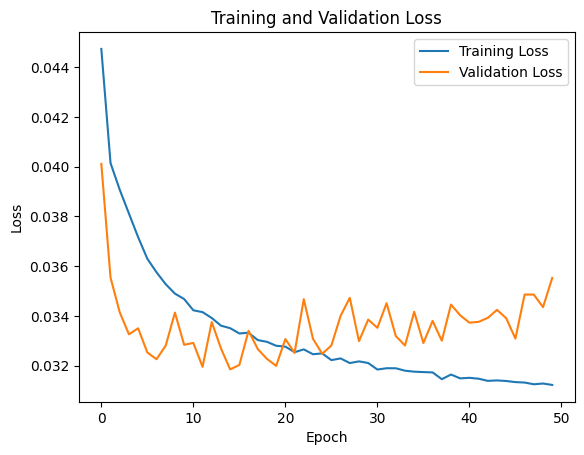

In [131]:
# Extract loss values from history
train_loss = history4.history['loss']
val_loss = history4.history['val_loss']

# Plot training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Plot the model.

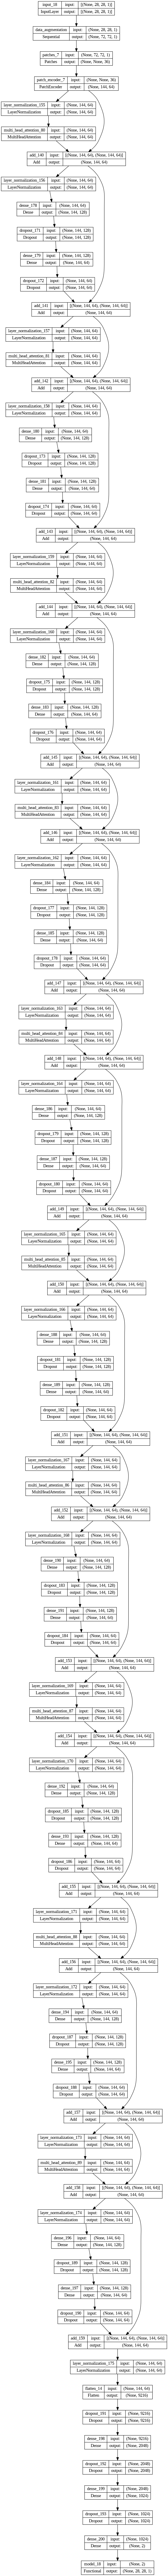

In [83]:
tf.keras.utils.plot_model(autoencoder, show_shapes=True)

Plotting both the noisy images and the denoised images produced by the autoencoder.

1/1 [==============================] - 0s 31ms/step


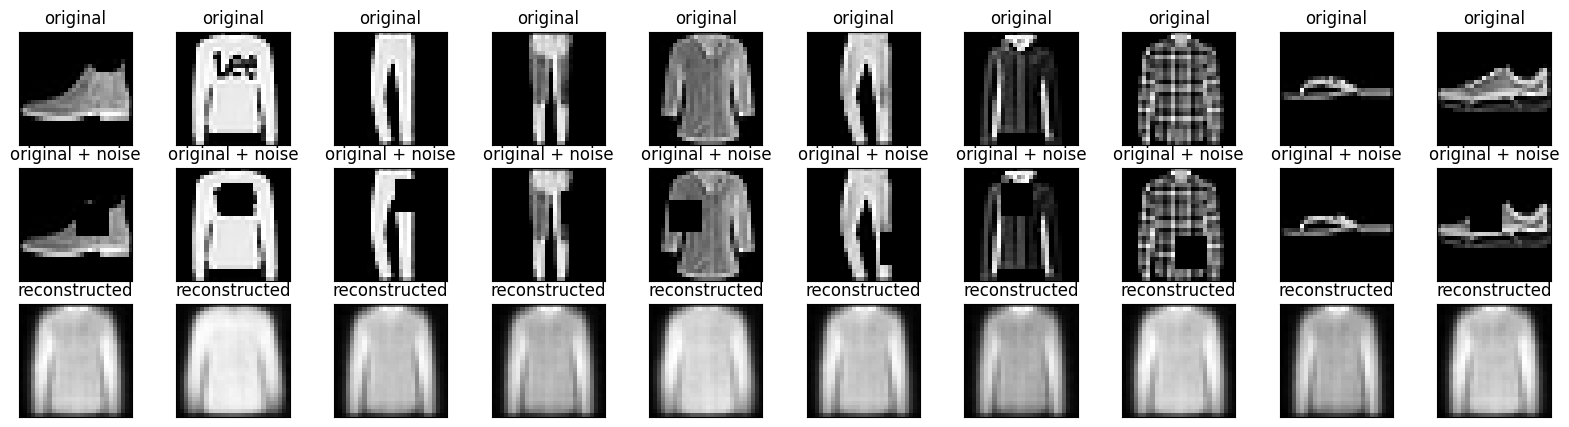

In [132]:
n = 10
plt.figure(figsize=(20, 5))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display original + noise
    ax = plt.subplot(3, n, i + n + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_masked[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(3, n, i + 2*n + 1)
    plt.title("reconstructed")
    reconstructed_img = autoencoder.predict(tf.expand_dims(x_test_noisy[i], axis=0)).reshape(28, 28)
    plt.imshow(tf.squeeze(reconstructed_img))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

plt.show()